In [7]:
pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import tensorflow as tf


os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow import keras
from tensorflow.keras.preprocessing import image

from PIL import Image

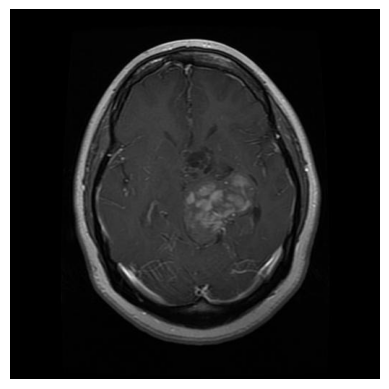

In [2]:
image_path = 'MRI_Scans/Training/glioma_tumor/gg (1).jpg'

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_width, image_height = 200, 200

# Create an ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    shear_range=0.2,  # Shear angle in counter-clockwise direction
    zoom_range=0.2,   # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    validation_split=0.2)  # Here we specify the validation split

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'MRI_Scans/Training/',
        target_size=(image_width, image_height),
        batch_size=32,
        class_mode='categorical',
        subset='training')  # Set as training data

# Flow validation images in batches using train_datagen generator
validation_generator = train_datagen.flow_from_directory(
        'MRI_Scans/Training/',  # point to the same directory as for the training data
        target_size=(image_width, image_height),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


Automated Hyper tuning

Tuner 1

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=256, step=32), (3, 3), activation=hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid']), input_shape=(image_width, image_height, 3)))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=256, step=32), (3, 3), activation=hp.Choice('activation2', values=['relu', 'tanh', 'sigmoid'])))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(hp.Int('conv3_units', min_value=32, max_value=256, step=32), (3, 3), activation=hp.Choice('activation3', values=['relu', 'tanh', 'sigmoid'])))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(hp.Int('conv4_units', min_value=32, max_value=256, step=32), (3, 3), activation=hp.Choice('activation4', values=['relu', 'tanh', 'sigmoid'])))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation=hp.Choice('activation_dense', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

Tuner 2

In [8]:
# Define the function to build the model 2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=256, step=32), (3, 3), activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'elu', 'selu']), input_shape=(image_width, image_height, 3)))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=256, step=32), (3, 3), activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'elu', 'selu'])))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(hp.Int('conv3_units', min_value=32, max_value=256, step=32), (3, 3), activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'elu', 'selu'])))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(hp.Int('conv4_units', min_value=32, max_value=256, step=32), (3, 3), activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'elu', 'selu'])))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Flatten())
    
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'elu', 'selu'])))
    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [9]:
# Initialize Keras Tuner
import kerastuner as kt
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 5,
    directory ='my_dir',
    project_name = 'activation_tuning')

Reloading Tuner from my_dir\activation_tuning\tuner0.json


In [6]:
    # Run the hyperparameter search
tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=10)

Trial 1 Complete [01h 11m 45s]
val_accuracy: 0.2879581153392792

Best val_accuracy So Far: 0.2879581153392792
Total elapsed time: 01h 11m 45s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
160               |224               |conv1_units
relu              |sigmoid           |activation1
128               |96                |conv2_units
sigmoid           |relu              |activation2
160               |256               |conv3_units
relu              |relu              |activation3
160               |32                |conv4_units
tanh              |sigmoid           |activation4
896               |896               |dense_units
sigmoid           |tanh              |activation_dense

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 319s 4s/step - accuracy: 0.2659 - loss: 4.3097 - val_accuracy: 0.2880 - val_loss: 1.3512
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 287s 4s/step - accuracy: 0.2845 - loss: 1.3700 - val_accuracy: 0.2880 - val_loss: 1.4012
Epoch 3/10
72/72 ━

KeyboardInterrupt: 

In [10]:
# Run the hyperparameter search #2
tuner.search(train_generator,
             validation_data=validation_generator,
             epochs = 10,
             callbacks=[early_stopping])

Trial 5 Complete [00h 24m 03s]
val_accuracy: 0.6823734641075134

Best val_accuracy So Far: 0.6823734641075134
Total elapsed time: 02h 27m 58s


In [11]:
# Get the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [4]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

NameError: name 'tuner' is not defined

In [14]:
# Print the summary of the top 3 hyperparameters
tuner.results_summary(num_trials=10)

Results summary
Results in my_dir\activation_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
conv1_units: 160
activation1: relu
conv2_units: 64
activation2: sigmoid
conv3_units: 192
activation3: relu
conv4_units: 96
activation4: tanh
dense_units: 896
activation_dense: sigmoid
activation: elu
dropout_rate: 0.30000000000000004
Score: 0.6823734641075134

Trial 3 summary
Hyperparameters:
conv1_units: 64
activation1: sigmoid
conv2_units: 128
activation2: tanh
conv3_units: 96
activation3: relu
conv4_units: 192
activation4: relu
dense_units: 896
activation_dense: tanh
activation: relu
dropout_rate: 0.1
Score: 0.6719022393226624

Trial 0 summary
Hyperparameters:
conv1_units: 224
activation1: sigmoid
conv2_units: 96
activation2: relu
conv3_units: 256
activation3: relu
conv4_units: 32
activation4: sigmoid
dense_units: 896
activation_dense: tanh
Score: 0.2879581153392792

Trial 1 summary
Hyperparameters:
conv1_units: 160
activation1:

In [16]:
# Train the model with early stopping (This was what I used to train the model)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs = 30,
                    callbacks=[early_stopping])

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.3328 - loss: 2.9112 - val_accuracy: 0.4293 - val_loss: 1.1614
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.6043 - loss: 0.9314 - val_accuracy: 0.5271 - val_loss: 1.1834
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6980 - loss: 0.7599 - val_accuracy: 0.5777 - val_loss: 1.0079
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.7200 - loss: 0.6818 - val_accuracy: 0.6545 - val_loss: 0.9056
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7563 - loss: 0.6267 - val_accuracy: 0.5846 - val_loss: 1.0384
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7601 - loss: 0.6123 - val_accuracy: 0.6876 - val_loss: 0.8754
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7685 - loss: 0.5616 - val_accuracy: 0.6353 - val_loss: 0.9209
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7940 - loss: 0.5260 - val_accuracy: 0.5742 - v

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 198, 198, 160)  │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 99, 99, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 97, 97, 64)     │        92,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 46, 46, 192)    │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 23, 23, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 21, 21, 96)     │       165,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 10, 10, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 896)            │     8,602,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         3,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,938,670 (102.76 MB)

 Trainable params: 8,979,556 (34.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,959,114 (68.51 MB)

In [22]:
# Get the final accuracy score
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Get the final loss scores
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final accuaracy and loss scores
print(f'Final Training Accuracy: {final_train_accuracy}')
print(f'Final Validation Accuracy: {final_val_accuracy}')
print(f'Final Training Loss: {final_train_loss}')
print(f'Final Validation Loss: {final_val_loss}')



Final Training Accuracy: 0.7962560057640076
Final Validation Accuracy: 0.5794066190719604
Final Training Loss: 0.5157857537269592
Final Validation Loss: 1.0440466403961182


In [8]:
# training the model (Original code. I did not use this version for training data accuracy)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

c:\Users\tyson\anaconda3\envs\tf\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 591ms/step - accuracy: 0.3623 - loss: 1.3168 - val_accuracy: 0.4688 - val_loss: 1.2316


In [3]:
# rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# create the test_generator
test_generator = test_datagen.flow_from_directory(
    'MRI_Scans/Testing/',
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# evaluate the model on the testing set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f'Test accuracy: {test_acc*100:.2f}%')


Found 394 images belonging to 4 classes.


NameError: name 'model' is not defined

# Actual test

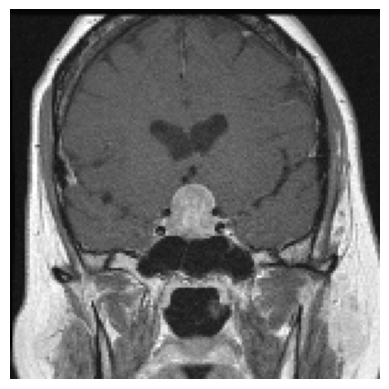

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to your specific image
image_path = 'MRI_Scans/Testing/pituitary_tumor/image(28).jpg'

# Load the image and resize it to match the input shape of your model
img = image.load_img(image_path, target_size=(image_width, image_height))

# Display the loaded image
plt.imshow(img)
plt.axis('off')  # Remove axes for clarity
plt.show()

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Rescale the image
img_array /= 255.

# extra dimension for the batch size
img_array = np.expand_dims(img_array, axis=0)

In [19]:
predictions = model.predict(img_array)

# Print
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.00564954 0.09760263 0.42692822 0.46981958]]


In [20]:
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class: {predicted_class}")

Predicted class: [3]


In [21]:
class_names = ['glioma', 'meningioma', 'no', 'pituitary'] 
print(f"Predicted class name: {class_names[predicted_class[0]]}")

Predicted class name: pituitary
